## Simulating sequences

Full simulation pipeline to get DNA sequences via msprime and seq-gen, as well as to create the site-count matrix.

In [1185]:
import msprime
import numpy as np
import dendropy
from dendropy.interop import seqgen
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
import time

First we name empty objects for our ML inputs

In [340]:
ml_feats = np.empty(shape = [0,256]).astype(int) # holds our data
ml_labels = np.empty(shape = [0,1]) # holds our labels

Now we set up some parameters for the simulations

In [1091]:
samplenum = 2000 # how many simulation samples
# make list of migration rates
mig_rate = np.append(np.random.gamma(shape = 1,  # make half of the rates positive and the other half zero
                                     scale=.00001,
                                     size = int(samplenum/2.)),
                     [0]*(int(samplenum/2.)))
np.random.shuffle(mig_rate)

# select window width 
win_width = [.05]*samplenum # if varying: np.random.uniform(0.03,0.1,size = 1000000)
# select window center 
win_center = [.5]*samplenum # if varying: np.random.uniform(0.1, 0.9, size = 1000000)
# get number of replicates
#num_reps_list = [10000]*samplenum # if varying: (5000+np.random.randint(1,15000,1000000))*2

Now we run simulations -- this is usually looped through a designated number of samples.

In [1214]:
sample = 0 # usually this is written as a loop, where the sample variable is the loop number
length = 10000
Ne = 1000000
mutation_rate = 7e-8
num_replicates = 1
recombination_rate = 1e-8

# Four tips of the tree
population_configurations = [msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                            msprime.PopulationConfiguration(sample_size=1,initial_size=250000),]

# No migration initially
migration_matrix = [[0.,0.,0.,0.],
                    [0.,0.,0.,0.],
                    [0.,0.,0.,0.],
                    [0.,0.,0.,0.],]

# Define demographic events for msprime
demographic_events = [msprime.MigrationRateChange(time=0,
                                                  rate=0),
                     msprime.MigrationRateChange(time=(win_center[sample]-win_width[sample]/2.)*4*Ne,
                                                 rate=mig_rate[sample],
                                                 matrix_index=[0,2]),
                     msprime.MigrationRateChange(time=(win_center[sample]+win_width[sample]/2.)*4*Ne,
                                                 rate=0),
                     msprime.MassMigration(destination=1,
                                           source=0,
                                           time=1.0*4*Ne,
                                           proportion=1),
                     msprime.MassMigration(destination=1, 
                                           source=2,
                                           time=1.2*4*Ne,
                                           proportion=1),
                     msprime.MassMigration(destination=1, 
                                           source=3,
                                           time=1.5*4*Ne,
                                           proportion=1)
                     ]

# Our msprime simulation:
simulation = msprime.simulate(length=length,
                 Ne=Ne,
                 mutation_rate=mutation_rate,
                 num_replicates=num_replicates,
                 recombination_rate=recombination_rate,
                 population_configurations=population_configurations,
                 migration_matrix = migration_matrix,         
                 demographic_events=demographic_events)


Once msprime sims are done, we want to input the trees to seq-gen. Notice that the sequence length from seq-gen is defined by the interval of the tree. I also scaled the branch lengths, but I did so kind of arbitrarily. 

In [1179]:
fullseq = None
all_labels = np.empty(shape = [0,1])
all_seqs = list()
for currsim in simulation:
    simtrees = currsim.trees()
    for currtree in simtrees:
        phylo = dendropy.TreeList.get(data = currtree.newick(),schema='newick')
        s = seqgen.SeqGen()
        s.seq_len = round(currtree.get_interval()[1]-currtree.get_interval()[0])
        s.scale_branch_lens = 0.0000001 # will have to consider how best to use this
        dnamat=s.generate(phylo)
        charmat=dnamat.char_matrices[0]
        for lab,seq in charmat.items():
            all_labels = np.append(all_labels,lab.label)
            all_seqs.append(seq.symbols_as_list())

### Why am I getting more than 10000 bases here?

In [1180]:
len(np.concatenate(np.array(all_seqs)[all_labels=='4']))

16007

In [1181]:
currsim.get_num_trees()

409

Now we want strings of sequences:

In [1161]:
seqs = np.vstack([np.concatenate(np.array(all_seqs)[all_labels == '1']),
                  np.concatenate(np.array(all_seqs)[all_labels == '2']),
                  np.concatenate(np.array(all_seqs)[all_labels == '3']),
                  np.concatenate(np.array(all_seqs)[all_labels == '4'])])
seqs = np.array([[ord(i) for i in q] for q in seqs])

And we convert the bases to our desired integers:

In [1163]:
# A=65, T=84, G=71, C=67 -> A=0, T=1, G=2, C=3
seqs[seqs == 65] = 0
seqs[seqs == 84] = 1
seqs[seqs == 71] = 2
seqs[seqs == 67] = 3

In [346]:
#AA, AT, AG, AC,  -> AA, AT, AG, AC, TA, TT, TG, TC, GA, GT, GG, GC, CA, CT, CG, CC
#TA, TT, TG, TC, 
#GA, GT, GG, GC, 
#CA, CT, CG, CC

Lastly, we get a matrix of the freqencies of site count patterns. 

In [347]:
index_1616 = np.array(range(16)).reshape([4,4])
matrix1616 = np.zeros(shape = [16,16]).astype(int)
for column in range(len(seqs[0])):
    current4=seqs[:,column]
    row1616 = int(index_1616[current4[0],current4[1]])
    column1616 = int(index_1616[current4[2],current4[3]])
    matrix1616[row1616,column1616] = int(matrix1616[row1616,column1616] + int(1))

In [82]:
ml_feats = np.vstack([ml_feats, matrix1616.reshape([1,256])[0]])

In [83]:
ml_feats

array([[ 9, 11,  5, 10, 13,  6, 11, 11,  7, 11,  9, 12,  6,  5,  5,  7,  9,
        10,  8, 12,  5, 13,  5,  6,  6,  5, 11,  9,  7,  8,  9,  7,  3,  8,
        13,  8,  8,  6,  9,  5,  9, 10,  8,  4,  7,  5,  6,  9,  4,  4, 16,
         3,  6,  6, 10,  3,  9,  5,  8,  7, 16, 10, 12, 17, 12,  9,  8, 11,
        13,  3, 14, 10, 10, 10, 10, 10, 11, 10,  5,  8, 11,  3,  4,  9,  5,
         7,  6, 12,  5, 15,  8,  7, 14,  7,  7, 15,  4, 12,  8,  9,  8, 14,
         5,  8,  5,  5,  9, 11,  4,  8,  7, 11, 10, 10,  7, 12,  6, 10,  7,
         4,  6, 12,  9,  9,  6,  6,  7,  6,  8,  9,  9,  8,  6,  6,  9,  5,
        11,  6,  7,  9,  6,  9,  7,  5,  6,  9, 11, 12, 15,  9, 12, 10,  5,
         4,  7,  5, 10,  6,  8,  6,  6, 15,  7,  8, 13, 12, 14,  8,  8,  6,
         2,  7,  7,  9,  6,  8,  8,  8,  7, 13,  8,  5,  8,  9, 10,  6,  7,
         5, 11,  8,  8, 11,  7, 11,  8,  9, 16,  8, 14,  5, 13,  5,  5,  9,
         9, 11, 13,  9,  5, 11,  9,  7, 12,  8, 13, 10,  7,  8, 11,  8,  4,
        10, 

Now let's write the whole thing out in one block:

In [ ]:
ml_feats = np.empty(shape = [0,256]).astype(int) # holds our data
ml_labels = np.empty(shape = [0,1]) # holds our labels

samplenum = 10000 # how many simulation samples
# make list of migration rates
mig_rate = np.append(np.random.gamma(shape = 1,  # make half of the rates positive and the other half zero
                                     scale=.00001,
                                     size = int(samplenum/2.)),
                     [0]*(int(samplenum/2.)))
np.random.shuffle(mig_rate)

# select window width 
win_width = [.05]*samplenum # if varying: np.random.uniform(0.03,0.1,size = 1000000)
# select window center 
win_center = [.5]*samplenum # if varying: np.random.uniform(0.1, 0.9, size = 1000000)
# get number of replicates
#num_reps_list = [10000]*samplenum # if varying: (5000+np.random.randint(1,15000,1000000))*2

for currsample in range(samplenum):
    sample = currsample # usually this is written as a loop, where the sample variable is the loop number
    length = 10000
    Ne = 1000000
    mutation_rate = 7e-8
    num_replicates = 1
    recombination_rate = 1e-8

    # Four tips of the tree
    population_configurations = [msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),
                                msprime.PopulationConfiguration(sample_size=1,initial_size=250000),]

    # No migration initially
    migration_matrix = [[0.,0.,0.,0.],
                        [0.,0.,0.,0.],
                        [0.,0.,0.,0.],
                        [0.,0.,0.,0.],]

    # Define demographic events for msprime
    demographic_events = [msprime.MigrationRateChange(time=0,
                                                      rate=0),
                         msprime.MigrationRateChange(time=(win_center[sample]-win_width[sample]/2.)*4*Ne,
                                                     rate=mig_rate[sample],
                                                     matrix_index=[0,2]),
                         msprime.MigrationRateChange(time=(win_center[sample]+win_width[sample]/2.)*4*Ne,
                                                     rate=0),
                         msprime.MassMigration(destination=1,
                                               source=0,
                                               time=1.0*4*Ne,
                                               proportion=1),
                         msprime.MassMigration(destination=1, 
                                               source=2,
                                               time=1.2*4*Ne,
                                               proportion=1),
                         msprime.MassMigration(destination=1, 
                                               source=3,
                                               time=1.5*4*Ne,
                                               proportion=1)
                         ]

    # Our msprime simulation:
    simulation = msprime.simulate(length=length,
                     Ne=Ne,
                     mutation_rate=mutation_rate,
                     num_replicates=num_replicates,
                     recombination_rate=recombination_rate,
                     population_configurations=population_configurations,
                     migration_matrix = migration_matrix,         
                     demographic_events=demographic_events)
    fullseq = None
    seqlength = 15
    all_labels = np.empty(shape = [0,1])
    all_seqs = list()
    for currsim in simulation:
        simtrees = currsim.trees()
        for currtree in simtrees:
            phylo = dendropy.TreeList.get(data = currtree.newick(),schema='newick')
            s = seqgen.SeqGen()
            s.seq_len = int(round(currtree.get_interval()[1]-currtree.get_interval()[0]))
            s.scale_branch_lens = 0.0000001 # will have to consider how best to use this
            dnamat=s.generate(phylo)
            charmat=dnamat.char_matrices[0]
            for lab,seq in charmat.items():
                all_labels = np.append(all_labels,lab.label)
                all_seqs.append(seq.symbols_as_list())
    seqs = np.vstack([np.concatenate(np.array(all_seqs)[all_labels == '1']),
                      np.concatenate(np.array(all_seqs)[all_labels == '2']),
                      np.concatenate(np.array(all_seqs)[all_labels == '3']),
                      np.concatenate(np.array(all_seqs)[all_labels == '4'])])
    seqs = np.array([[ord(i) for i in q] for q in seqs])
    # A=65, T=84, G=71, C=67 -> A=0, T=1, G=2, C=3
    seqs[seqs == 65] = 0
    seqs[seqs == 84] = 1
    seqs[seqs == 71] = 2
    seqs[seqs == 67] = 3

    index_1616 = np.array(range(16)).reshape([4,4])
    matrix1616 = np.zeros(shape = [16,16]).astype(int)
    for column in range(len(seqs[0])):
        current4=seqs[:,column]
        row1616 = int(index_1616[current4[0],current4[1]])
        column1616 = int(index_1616[current4[2],current4[3]])
        matrix1616[row1616,column1616] = int(matrix1616[row1616,column1616] + int(1))

    ml_feats = np.vstack([ml_feats, matrix1616.reshape([1,256])[0]])
    ml_labels = np.vstack([ml_labels, mig_rate[sample]])
    print(sample)
    print(mig_rate[sample])

0
3.11531857544e-05
1
0.0
2
5.04366169644e-06
3
0.0
4
0.0
5
0.0
6
5.72230782712e-06
7
0.0
8
0.0
9
0.0
10
0.0
11
0.0
12
0.0
13
9.15673797732e-06
14
0.0
15
0.0
16
8.00638037238e-06
17
1.02483899896e-05
18
0.0
19
8.73999995928e-06
20
0.0
21
0.0
22
0.0
23
0.0
24
3.3748656123e-06
25
1.07838806255e-05
26
4.78544981739e-07
27
0.0
28
1.61338770905e-06
29
0.0
30
1.51197066668e-05
31
0.0
32
1.81393776527e-07
33
5.72688276262e-06
34
0.0
35
1.26985902783e-05
36
5.79184977714e-06
37
0.0
38
2.67692922841e-06
39
0.0
40
2.57618470973e-05
41
0.0
42
0.0
43
0.0
44
6.1844165965e-06
45
0.0
46
0.0
47
4.75574735505e-06
48
0.0
49
0.0
50
1.16460262858e-05
51
0.0
52
2.0214008513e-05
53
6.99654410513e-06
54
0.0
55
0.0
56
1.45088619879e-06
57
0.0
58
0.0
59
8.33773566698e-06
60
1.00801497093e-05
61
0.0
62
0.0
63
0.0
64
3.1736994292e-06
65
2.28667946736e-06
66
0.0
67
2.23873810788e-05
68
4.32916142199e-06
69
1.19425252563e-05
70
6.96822417541e-06
71
0.0
72
4.00706964808e-06
73
5.98443126861e-06
74
0.0
75
4.17369192

Now save our data in hdf5 in case we want to stack onto it later.

In [864]:
import h5py
f = h5py.File("sim_counts2.hdf5", "w")
f.create_dataset("labels", (len(ml_labels),))
f.create_dataset("matrices",(ml_feats.shape),dtype = 'i')
f['labels'][...] = ml_labels.reshape(1,-1)[0]
f['matrices'][...] = ml_feats
f.close()

Transform it using the l1 norm

In [865]:
norm=preprocessing.Normalizer(copy=False,norm='l1')
trans_norm = norm.transform(ml_feats)

This is how we'd use scaling if we were doing that, but our norm transformation should be good enough?

In [1015]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(ml_feats)  
scaled = scaler.transform(ml_feats)

/Users/pmckenz1/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Classification:
First change our migration rate list to a binary integer list.

In [868]:
int_mig_rate=(mig_rate > 0).astype(int)

Train the model on the first group of instances:

In [870]:
from sklearn import svm
X = scaled[0:1000]
y = int_mig_rate[0:1000]
clf = svm.SVC(C=10000)
clf.fit(X, y)  

SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Make a sorted test set from the last group of instances:

In [871]:
testset = np.empty(shape=[0,257])
for i in range(1000,1100):
    testset=np.vstack([testset,np.append(mig_rate[i],scaled[i])])

In [872]:
testset[:,0] = (testset[:,0] > 0).astype(int)
sorted_test= testset[testset[:,0].argsort()]

### Correct classifications:

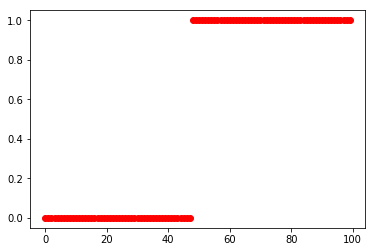

In [873]:
plt.plot(sorted_test[:,0], 'ro')
plt.show()

### Predicted classifications:

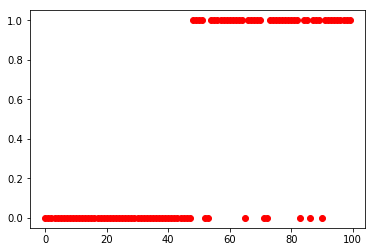

In [874]:
plt.plot(clf.predict(sorted_test[:,1:257]),'ro')
plt.show()

### Regression doesn't work as well for now.

Fitting an SVM regression

In [1085]:
from sklearn import svm
X = trans_norm[0:1000]
y = mig_rate[0:1000]
regr = svm.SVR(C=1000,epsilon=.01)
regr.fit(X, y)  

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=1e-28, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [1086]:
testset = np.empty(shape=[0,257])
for i in range(1000,1100):
    testset=np.vstack([testset,np.append(mig_rate[i],trans_norm[i])])

In [1087]:
#testset[:,0] = (testset[:,0] > 0).astype(int)
sorted_test= testset[testset[:,0].argsort()]

### Real answers

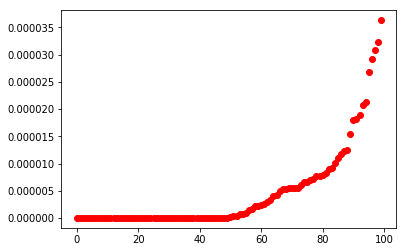

In [1088]:
plt.plot(sorted_test[:,0], 'ro')
plt.show()

### Predicted answers

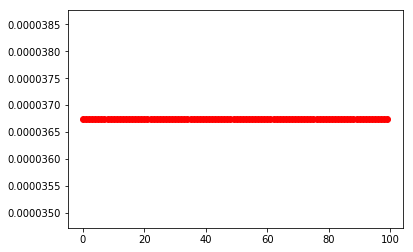

In [1089]:
plt.plot(regr.predict(sorted_test[:,1:257]),'ro')
plt.show()

### Are the matrices with migration even different? Let's try PCA to visualize this.

In [584]:
from sklearn.decomposition import KernelPCA

Set up and fit PCA

In [1054]:
rbf_pca = KernelPCA(n_components=2, kernel = 'rbf', gamma = .0004)

In [1055]:
X_red = rbf_pca.fit_transform(trans_norm)

Sort our labeled instances into different bins

In [1056]:
zeros = X_red[(int_mig_rate==0)[0:len(trans_norm)],:]
ones = X_red[(int_mig_rate==1)[0:len(trans_norm)],:]

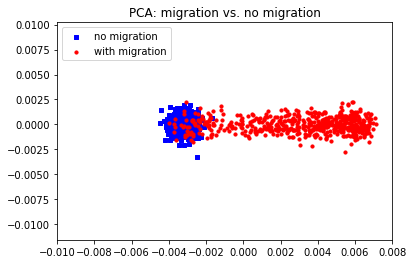

In [1057]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(zeros[:,0]*10,zeros[:,1]*10, s=10, c='b', marker="s", label='no migration')
ax1.scatter(ones[:,0]*10,ones[:,1]*10, s=10, c='r', marker="o", label='with migration')
plt.legend(loc='upper left');
plt.title("PCA: migration vs. no migration")
plt.show()

This is a promising result, implying that we should be able to distinguish matrices with varying levels of migration.

### Trying a gradient boosting regressor

In [819]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(trans_norm,ml_labels.reshape(1,-1)[0])

In [889]:
gbrt=GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)
bst_n_estimators

0

In [994]:
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=12)
gbrt_best.fit(trans_norm[0:1000], ml_labels.reshape(1,-1)[0][0:1000])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=12, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

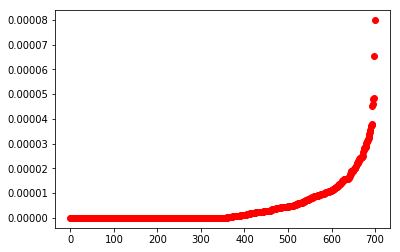

In [822]:
plt.plot(sorted_test[:,0], 'ro')
plt.show()

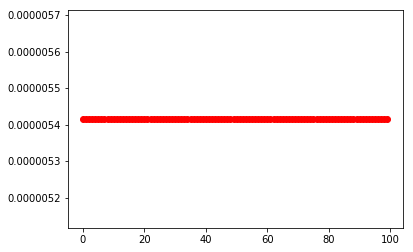

In [995]:
plt.plot(gbrt_best.predict(sorted_test[:,1:257]),'ro')
plt.show()

### Trying a basic neural network.

In [664]:
from sklearn.neural_network import MLPRegressor

In [1013]:
neuralnet = MLPRegressor(solver='lbfgs', alpha=1e-3,hidden_layer_sizes=(12,3), random_state=7, max_iter=100000,
                        tol=1e-1,momentum = 0.2,batch_size = 100, power_t = .5)
X = trans_norm[0:1000]
y = mig_rate[0:1000]
neuralnet.fit(X,y)

MLPRegressor(activation='relu', alpha=0.001, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000, momentum=0.2,
       nesterovs_momentum=True, power_t=0.5, random_state=7, shuffle=True,
       solver='lbfgs', tol=0.1, validation_fraction=0.1, verbose=False,
       warm_start=False)

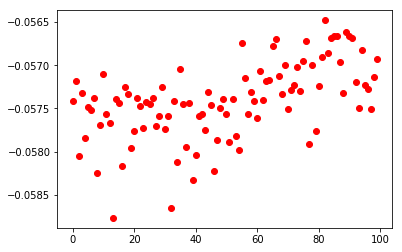

In [1014]:
plt.plot(neuralnet.predict(sorted_test[:,1:257]),'ro')
plt.show()

Still stuck on why I'm getting such strange results from the regressors.